In [140]:
from __future__ import absolute_import, division, print_function

import torch
from torch.distributions import constraints
from torch.nn import Parameter

import pyro
from pyro.contrib.gp.util import Parameterized
import pyro.distributions as dist
import pyro.infer as infer
import pyro.optim as optim
from pyro.params import param_with_module_name
import pyro.contrib.gp as gp
import pyro.distributions as dist
import matplotlib.pyplot as plt
pyro.clear_param_store()
import tensorflow as tf
import numpy as np 
import pandas as pd
import numpy
import math
import cProfile
import time
import pods
np.random.seed(0)
torch.manual_seed(101)
pyro.set_rng_seed(1)

In [141]:
def d_euclidean(a,b):
    """Returns euclidean distance between vectors a and b"""

    return math.sqrt(sum([ (x - y)**2 for (x,y) in zip (a,b) ]))
def rank_matrix(x):
    """Returns rank matrix from pairwise distance matrix a"""
    
    m = x.argsort()
    r = numpy.zeros(x.shape)

    vectors = x.shape[0]

    for i in range(vectors):
        for j in range(vectors):
            pos = numpy.where(m[i,:]==j)
            r[i,j] = pos[0][0] # there should be a better syntax for this
        
    return r.astype('int')


def centering(x):
    """Center matrix x to origo"""
    return x - x.mean(axis=0)


def double_centering(x):
    """Double center matrix x"""
    pass

def distance_matrix(x, distf=None):
    """Returns distance matrix of pairwise distances between vectors
    stored in array a

    distf is function used to calculate distance between vectors,
    if None, euclidean distance is used
    """

    if distf == None:
        distf = d_euclidean

    vectors = x.shape[0]
    d = numpy.zeros([vectors, vectors])

    for i in range(vectors):
        for j in range(i,vectors):
            dd = distf(x[i,:], x[j,:])
            d[i,j] = dd
            d[j,i] = dd

    return d
def moved_out(nn_orig, nn_proj, i, k):
    """Determine points that were neighbours in the original space,
    but are not neighbours in the projection space.

    nn_orig
      neighbourhood matrix for original data

    nn_proj
      neighbourhood matrix for projection data

    i
      index of the point considered

    k
      size of the neighbourhood considered

    Return a list of indices for 'moved out' values 
    """

    oo = list(nn_orig[i, 1:k+1])
    pp = list(nn_proj[i, 1:k+1])

    for j in pp:
        if (j in pp) and (j in oo):
            oo.remove(j)

    return oo
def moved_in(nn_orig, nn_proj, i, k):
    """Determine points that are neighbours in the projection space,
    but were not neighbours in the original space.

    nn_orig
      neighbourhood matrix for original data

    nn_proj
      neighbourhood matrix for projection data

    i
      index of the point considered

    k
      size of the neighbourhood considered

    Return a list of indices for points which are 'moved in' to point i
    """

    pp = list(nn_proj[i, 1:k+1])
    oo = list(nn_orig[i, 1:k+1])

    for j in oo:
        if (j in oo) and (j in pp):
            pp.remove(j)

    return pp


def scaling_term(k, n):
    """Term that scales measure between zero and one

    k  size of the neighbourhood
    n  number of datapoints
    """

    if k < (n / 2.0):
        return 2.0 / ((n*k)*(2*n - 3*k - 1))
    else:
        return 2.0 / (n * (n - k) * (n - k - 1))


def trustcont_sum(moved, ranks, k):
    """Calculate sum used in trustworthiness or continuity calculation.

    moved

       List of lists of indices for those datapoints that have either
       moved away in (Continuity) or moved in (Trustworthiness)
       projection

    ranks

       Rank matrix of data set. For trustworthiness, ranking is in the
       original space, for continuity, ranking is in the projected
       space.

    k
       size of the neighbournood
    """

    n = ranks.shape[0]
    s = 0

    # todo: weavefy this for speed
    for i in range(n):
        for j in moved[i]:
            s = s + (ranks[i, j] - k)

    a = scaling_term(k, n)

    return 1 - a * s

In [159]:
data = pods.datasets.oil_100()

In [211]:
#Y = tf.convert_to_tensor(data['X'], np.float32)
#Y = tf.pack(data['X'])
#tf.InteractiveSession()
#evaluated_tensor = Y.eval()
#Y.shape
#tensor2 = tf.reshape(Y, tf.TensorShape([100*12, 1]))
#rows, columns = map(lambda i: i.value, Y.get_shape())
#Y.get_shape().as_list()
#tensor2 = tf.reshape(Y, tf.TensorShape([100, 12]))
#tensor2.shape
Y=data['X'].T
Y = torch.Tensor(Y)
Y.shape

torch.Size([12, 100])

In [212]:
X_loc = torch.zeros(100,7)

In [213]:
kernel = gp.kernels.RBF(input_dim=7, lengthscale=torch.ones(7))

In [214]:
Xu = torch.zeros(20, 7)  # initial inducing inputs of sparse model

In [215]:
gpmodel = gp.models.SparseGPRegression(X_loc, Y, kernel, Xu, noise=torch.tensor(1.))
gplvm = gp.models.GPLVM(gpmodel)

CPU+SystemTime:28.109375 seconds
Code Run Time:28.237625122070312 seconds


Text(0.5,1,'Convergence of SVI')

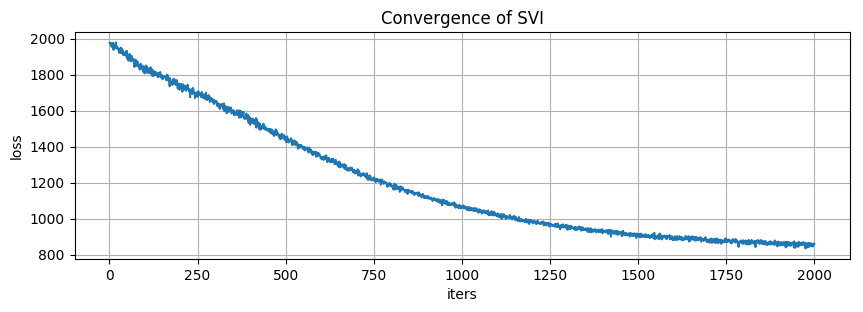

In [216]:
from matplotlib import pyplot

i=list(range(1,2001))
#cProfile.run('gplvm.optimize(num_steps=2000)')
st = time.process_time()
st2 = time.time()
losses = gplvm.optimize(num_steps=2000)  # doctest: +SKIP
end =  time.process_time()
end2 = time.time()
print(str('CPU+SystemTime:')+str(end-st)+' '+str('seconds'))
print(str('Code Run Time:')+str(end2-st2)+' '+str('seconds'))
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(i,losses)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.grid()
#pyplot.yscale('log')
pyplot.title('Convergence of SVI')



In [217]:
X = gplvm.get_param("X_loc")
X = X.detach().numpy()
X.shape

(100, 7)

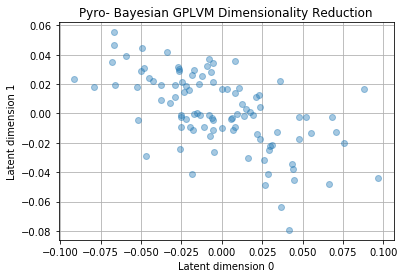

In [218]:
plt.plot(X[:,0],X[:,1],linestyle="",alpha=0.4,marker="o")
pyplot.xlabel('Latent dimension 0')
pyplot.ylabel('Latent dimension 1')
pyplot.title('Pyro- Bayesian GPLVM Dimensionality Reduction')
pyplot.grid()

In [219]:
X.shape
Y = numpy.array(Y)
Y = Y.T
Y.shape

(100, 12)

In [220]:
dd_orig = distance_matrix(Y)
dd_proj = distance_matrix(X)
nn_orig = dd_orig.argsort()
nn_proj = dd_proj.argsort()
ranks_proj = rank_matrix(dd_proj)

Neearest neighbourboost size k =2 Continuity:0.7686528497409326
Neearest neighbourboost size k =4 Continuity:0.7641978609625668
Neearest neighbourboost size k =6 Continuity:0.7594106813996317
Neearest neighbourboost size k =8 Continuity:0.7604


Text(0.5,1,'Continuity vs Nearest Neighbour Classification Size')

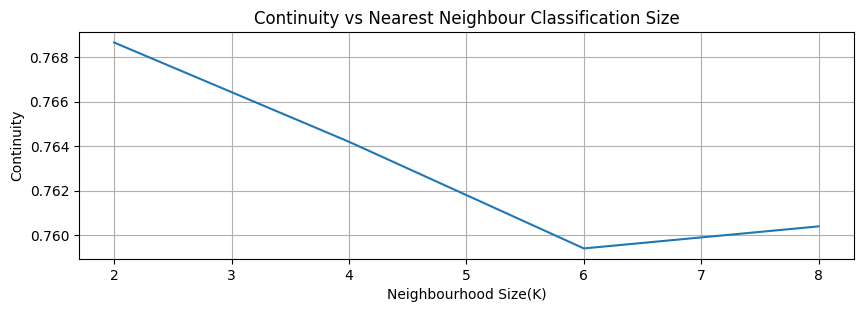

In [221]:
cont = []
ks=[2,4,6,8]
j=0
for k in ks:
    moved = []
    for i in range(Y.shape[0]):
        moved.append(moved_out(nn_orig, nn_proj, i, k))
    cont.append(trustcont_sum(moved, ranks_proj, k))
    print('Neearest neighbourboost size k =' + str(k)+ ' ' + 'Continuity:' + str(cont[j]))
    j+=1
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(ks,cont)
pyplot.grid()
pyplot.xlabel('Neighbourhood Size(K)')
pyplot.ylabel('Continuity')
pyplot.title('Continuity vs Nearest Neighbour Classification Size')

Neearest neighbourboost size k =2 Trust:0.71139896373057
Neearest neighbourboost size k =4 Trust:0.7262299465240643
Neearest neighbourboost size k =6 Trust:0.7188950276243093
Neearest neighbourboost size k =8 Trust:0.7131714285714286


Text(0.5,1,'Trust vs Nearest Neighbour Classification Size')

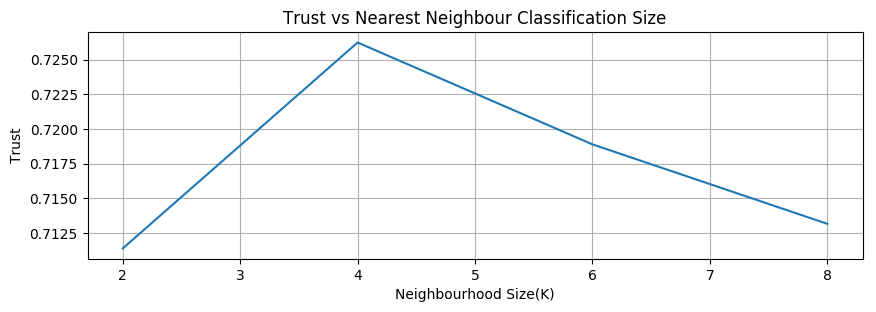

In [222]:
ranks_orig =rank_matrix(dd_orig)
trust = []
j=0
for k in ks:
    moved = []
    for i in range(Y.shape[0]):
        moved.append(moved_in(nn_orig, nn_proj, i, k))
    trust.append(trustcont_sum(moved, ranks_orig, k))
    print('Neearest neighbourboost size k =' + str(k)+ ' ' + 'Trust:' + str(trust[j]))
    j+=1
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(ks,trust)
pyplot.grid()
pyplot.xlabel('Neighbourhood Size(K)')
pyplot.ylabel('Trust')
#pyplot.yscale('log')
pyplot.title('Trust vs Nearest Neighbour Classification Size')

In [233]:
import GPy
import numpy as np
from matplotlib import pyplot as plt
data = pods.datasets.oil_100()

In [234]:
kernel = GPy.kern.RBF(7, ARD=True,)
Y = data['X']
m = GPy.models.GPLVM(Y, 7,  init="PCA",kernel=kernel)
m.data_labels = Y.argmax(axis=1)

Running Scaled Conjugate Gradients Code:
  runtime   i      f              |g|        
    00s00  0001  -3.686163e+03   7.926656e+04 
    00s03  0006  -3.686165e+03   4.194237e+04 
    00s10  0019  -3.686177e+03   4.159240e+04 
    00s19  0036  -3.686188e+03   3.968928e+04 
    03s19  0943  -3.687497e+03   9.055988e+04 
    11s20  3232  -3.699096e+03   1.949913e+05 
    21s09  6002  -3.705498e+03   2.223113e+05 
Runtime:     21s09
Optimization status: maxiter exceeded

CPU+SystemTime:103.109375 seconds
Code Run Time:21.09969401359558 seconds


Text(0.5,1,'Loss Function')

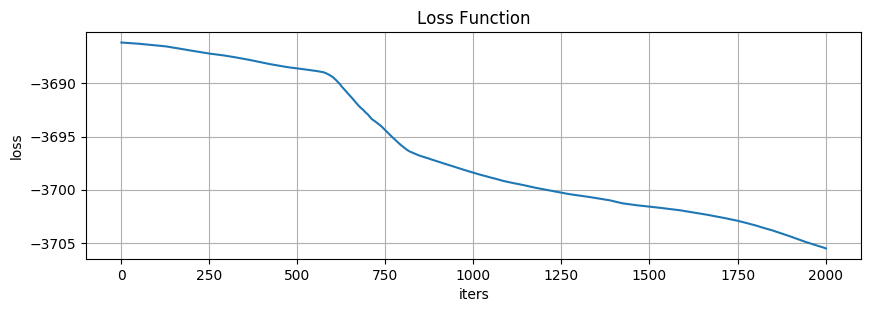

In [244]:
verbose=1
st =  time.process_time()
st2 = time.time()
loss = m.optimize('scg', messages=verbose,max_iters=2000)
end =  time.process_time()
end2 = time.time()
max_iters=2000
print(str('CPU+SystemTime:')+str(end-st)+' '+str('seconds'))
print(str('Code Run Time:')+str(end2-st2)+' '+str('seconds'))
i=list(range(1,max_iters+2))
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.grid()
pyplot.plot(i,loss.trace)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
#pyplot.yscale('log')
pyplot.title('Loss Function')

In [252]:
Y = numpy.array(Y)
Y = Y.T
Y

array([[ 0.6022,  0.4851,  0.9271, ..., -0.1692,  0.021 ,  1.7062],
       [ 0.7532,  0.3612,  0.3635, ...,  0.6552,  0.3743,  1.0184],
       [ 0.5023,  0.2296,  0.8095, ...,  0.5025,  0.7605,  0.3984],
       ...,
       [ 0.1269,  0.9731,  0.412 , ...,  2.0243, -0.011 ,  1.7438],
       [ 0.0965,  0.088 ,  0.0599, ...,  0.168 ,  0.1162,  0.1799],
       [ 0.4141,  0.2904,  0.6394, ...,  2.0185, -0.0349,  0.0416]])

 /home/aneeqr/.local/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


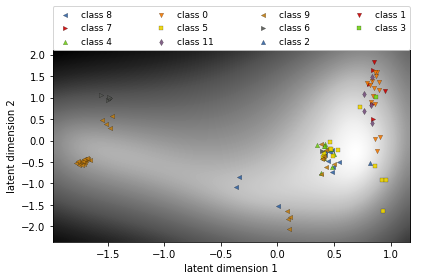

In [253]:
m.plot_latent(labels=m.data_labels)

 /home/aneeqr/.local/lib/python3.6/site-packages/matplotlib/__init__.py:1855: MatplotlibDeprecationWarning:The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0


(100, 7)

 /home/aneeqr/.local/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


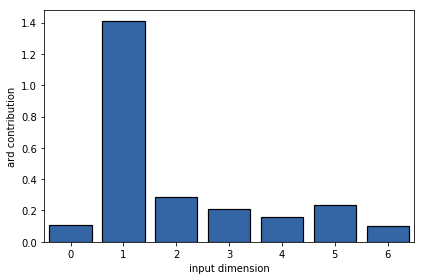

In [247]:
m.kern.plot_ARD()
m.X.shape

In [254]:
dd_orig = distance_matrix(Y)
dd_proj = distance_matrix(m.X)
nn_orig = dd_orig.argsort()
nn_proj = dd_proj.argsort()
ranks_proj = rank_matrix(dd_proj)

Neearest neighbourboost size k =2 Continuity:0.9704663212435233
Neearest neighbourboost size k =4 Continuity:0.9529679144385027
Neearest neighbourboost size k =6 Continuity:0.9233333333333333
Neearest neighbourboost size k =8 Continuity:0.8995857142857143


Text(0.5,1,'Continuity vs Nearest Neighbour Classification Size')

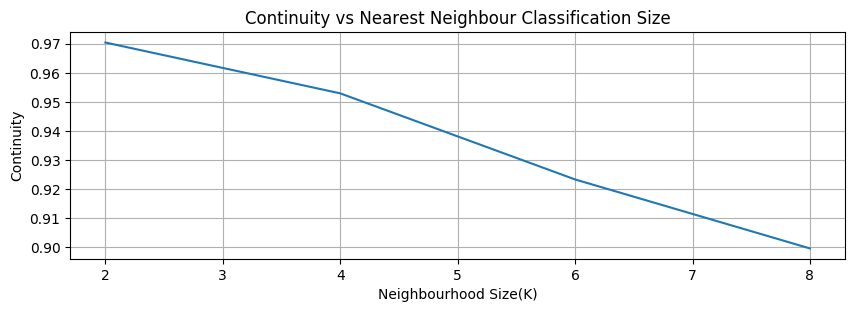

In [257]:
j=0
cont=[]
for k in ks:
    moved = []
    for i in range(Y.shape[0]):
        moved.append(moved_out(nn_orig, nn_proj, i, k))
    cont.append(trustcont_sum(moved, ranks_proj, k))
    print('Neearest neighbourboost size k =' + str(k)+ ' ' + 'Continuity:' + str(cont[j]))
    j+=1
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(ks,cont)
pyplot.xlabel('Neighbourhood Size(K)')
pyplot.ylabel('Continuity')
pyplot.grid()
#pyplot.yscale('log')
pyplot.title('Continuity vs Nearest Neighbour Classification Size')

Neearest neighbourboost size k =2 Trust:0.9770466321243523
Neearest neighbourboost size k =4 Trust:0.9705882352941176
Neearest neighbourboost size k =6 Trust:0.9449171270718232
Neearest neighbourboost size k =8 Trust:0.9240857142857143


Text(0.5,1,'Trust vs Nearest Neighbour Classification Size')

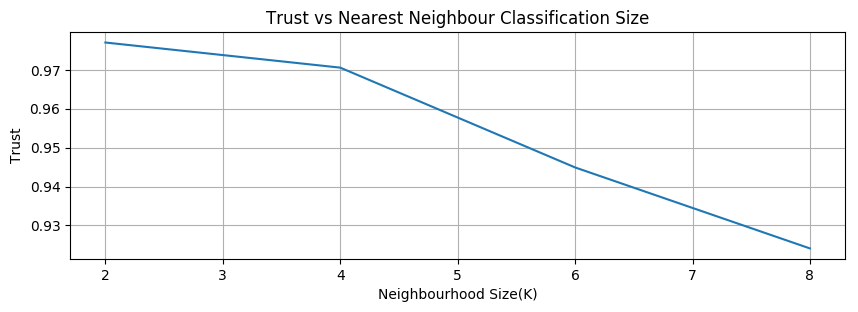

In [258]:
ranks_orig =rank_matrix(dd_orig)
trust = []
j=0
for k in ks:
    moved = []
    for i in range(Y.shape[0]):
        moved.append(moved_in(nn_orig, nn_proj, i, k))
    trust.append(trustcont_sum(moved, ranks_orig, k))
    print('Neearest neighbourboost size k =' + str(k)+ ' ' + 'Trust:' + str(trust[j]))
    j+=1
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(ks,trust)
pyplot.grid()
pyplot.xlabel('Neighbourhood Size(K)')
pyplot.ylabel('Trust')
pyplot.title('Trust vs Nearest Neighbour Classification Size')

# Bayesian GPLVM

In [262]:
Q=7
num_inducing=40
N=200
max_iters = 2000
verbose=1
k = GPy.kern.RBF(Q, ARD=True,)
#k = GPy.kern.RBF(Q, 1., 1. / np.random.uniform(0, 1, (Q,)), ARD=True)  # + GPy.kern.Bias(Q, _np.exp(-2))
Y = data['X']
m = GPy.models.BayesianGPLVM(Y, Q, kernel=k, num_inducing=num_inducing)
m.data_labels = data['Y'].argmax(axis=1)

Running Scaled Conjugate Gradients Code:
  runtime   i      f              |g|        
    00s09  0005   3.081310e+04   6.756999e+04 
    00s19  0010   4.738813e+03   7.536058e+04 
    03s22  0178   1.941597e+02   3.643214e+03 
    04s22  0232   1.439297e+02   9.901780e+02 
    07s25  0390   2.303162e+01   3.859781e+02 
    23s36  1214  -1.608854e+02   2.667935e+02 
    33s45  1725  -2.172372e+02   1.598682e+02 
 01m14s91  3792  -2.537398e+02   1.183131e+01 
 01m59s78  5994  -2.592636e+02   5.695348e+00 
Runtime:  01m59s78
Optimization status: maxiter exceeded

CPU+SystemTime:871.328125 seconds
Code Run Time:119.82415318489075 seconds


Text(0.5,1,'Loss Function')

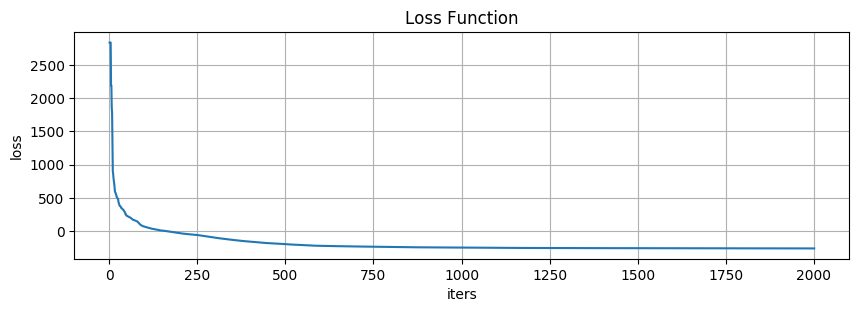

In [263]:
verbose=1
st =  time.process_time()
st2 = time.time()
loss = m.optimize('scg', messages=verbose, max_iters=max_iters, gtol=.001)
end =  time.process_time()
end2 = time.time()
max_iters=2000
print(str('CPU+SystemTime:')+str(end-st)+' '+str('seconds'))
print(str('Code Run Time:')+str(end2-st2)+' '+str('seconds'))
i=list(range(1,max_iters+2))
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.grid()
pyplot.plot(i,loss.trace)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.title('Loss Function')

 /home/aneeqr/.local/lib/python3.6/site-packages/matplotlib/__init__.py:1855: MatplotlibDeprecationWarning:The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0


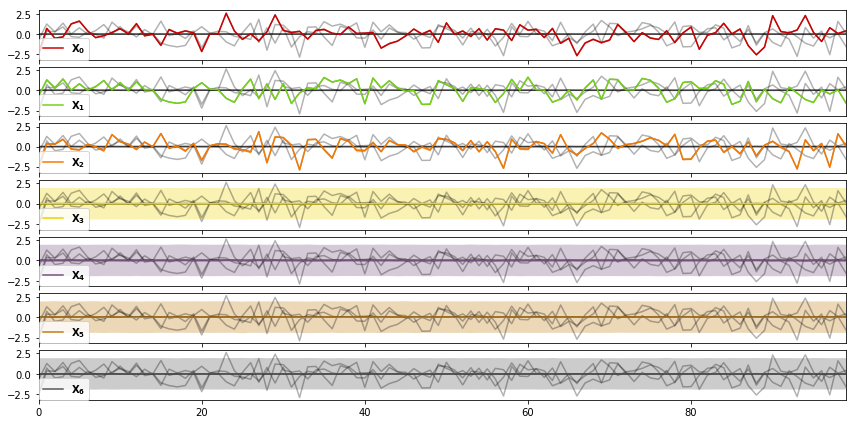

 /home/aneeqr/.local/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


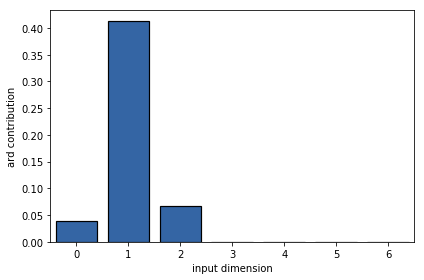

In [273]:

m.X.plot("BGPLVM Latent Space 1D")
m.kern.plot_ARD()

In [268]:
X0= list(m.X.mean[:,0])
X1= list(m.X.mean[:,1])
t= np.column_stack((X0, X1))
dd_proj = distance_matrix(t)
nn_orig = dd_orig.argsort()
nn_proj = dd_proj.argsort()
ranks_proj = rank_matrix(dd_proj)

Neearest neighbourboost size k =2 Continuity:0.9799481865284974
Neearest neighbourboost size k =4 Continuity:0.9712032085561497
Neearest neighbourboost size k =6 Continuity:0.9661510128913444
Neearest neighbourboost size k =8 Continuity:0.9603285714285714


Text(0.5,1,'Continuity vs Nearest Neighbour Classification Size')

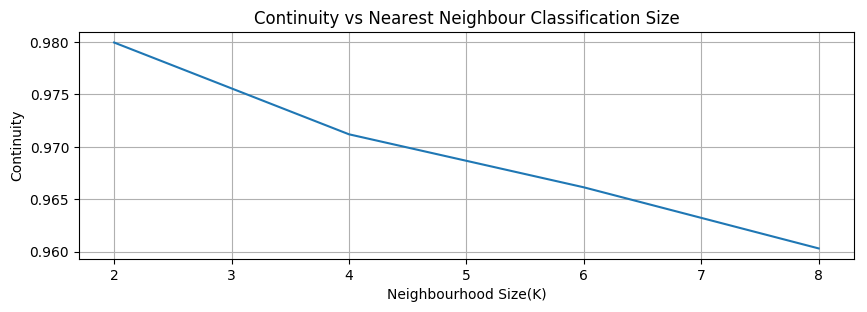

In [269]:
j=0
cont=[]
for k in ks:
    moved = []
    for i in range(Y.shape[0]):
        moved.append(moved_out(nn_orig, nn_proj, i, k))
    cont.append(trustcont_sum(moved, ranks_proj, k))
    print('Neearest neighbourboost size k =' + str(k)+ ' ' + 'Continuity:' + str(cont[j]))
    j+=1
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(ks,cont)
pyplot.grid()
pyplot.xlabel('Neighbourhood Size(K)')
pyplot.ylabel('Continuity')
#pyplot.yscale('log')
pyplot.title('Continuity vs Nearest Neighbour Classification Size')

Neearest neighbourboost size k =2 Trust:0.9319689119170984
Neearest neighbourboost size k =4 Trust:0.929144385026738
Neearest neighbourboost size k =6 Trust:0.9279005524861879
Neearest neighbourboost size k =8 Trust:0.9191714285714285


Text(0.5,1,'Trust vs Nearest Neighbour Classification Size')

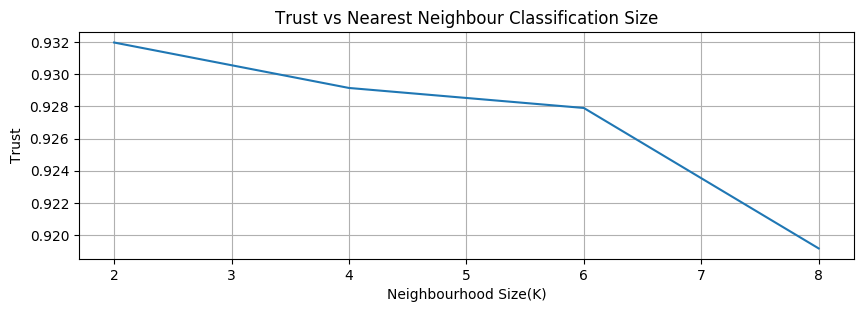

In [270]:
ranks_orig =rank_matrix(dd_orig)
trust = []
j=0
for k in ks:
    moved = []
    for i in range(Y.shape[0]):
        moved.append(moved_in(nn_orig, nn_proj, i, k))
    trust.append(trustcont_sum(moved, ranks_orig, k))
    print('Neearest neighbourboost size k =' + str(k)+ ' ' + 'Trust:' + str(trust[j]))
    j+=1
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(ks,trust)
pyplot.grid()
pyplot.xlabel('Neighbourhood Size(K)')
pyplot.ylabel('Trust')
#pyplot.yscale('log')
pyplot.title('Trust vs Nearest Neighbour Classification Size')